## Purpose

Cluster time series using DBSCAN

In [1]:
import os 
import sys
import numpy as np
from collections import defaultdict
import CAN_objects.aid_message
import matplotlib.pyplot as plt


actt_path = os.path.join(os.path.join(os.path.expanduser("~"), "Projects", "CAN", "actt"))
os.chdir(actt_path)
sys.path.insert(0, "src") # add src folder to path so that files from this folder can be imported

from generalFunctions import unpickle
import subprocess

import importlib
importlib.reload(CAN_objects.aid_message)
from init_cancapture_from_canlog import init_cancap
import json
import seaborn as sns
import pandas as pd

from CAN_objects.capture import MappedCapture, MatchedCapture
import math
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster

from pprint import pprint
from sklearn.metrics.cluster import normalized_mutual_info_score

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

import glob
from tqdm import tqdm
import itertools
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler

from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors

## Enable the Use of Functions From the Detect Repo

In [2]:
# sys.path.insert(0, "/home/cades/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
sys.path.insert(0, "/home/cloud/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
import signal_based_preprocess_functions
print(os.getcwd())

/home/cloud/Projects/CAN/actt


## Functions

In [6]:
def from_capture_to_time_series(cap, ground_truth_dbc_path):
    
    signal_multivar_ts, timepts, aid_signal_tups = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap, ground_truth_dbc_path)

    return signal_multivar_ts, timepts, aid_signal_tups


def from_captures_to_time_series(cap_1, cap_2, ground_truth_dbc_path):
        
    signal_multivar_ts_1, timepts_1, aid_signal_tups_1 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_1, ground_truth_dbc_path)
    signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_2, ground_truth_dbc_path)

    return signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2


def from_single_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    display(df_1)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df_1)
    # df_1.dtypes
    
    # df_1_scaled = normalize(df_1) # scale
    # df_1_scaled = pd.DataFrame(df_1_scaled, columns=df_1.columns)
    df_1_scaled = (df_1-df_1.min())/(df_1.max()-df_1.min())
    df_1 = df_1_scaled
    display(df_1)

    # Compute correlation matrix
    corr_matrix_1 = df_1.corr(method="pearson")
    # display(corr_matrix_1)
    # display(corr_matrix_1.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_1 = corr_matrix_1.columns.values

    
    return corr_matrix_1, signal_names_1


def from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    display(df_1)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df_1)
    # df_1.dtypes
    
    df_1_scaled = normalize(df_1) # scale
    df_1_scaled = pd.DataFrame(df_1_scaled, columns=df_1.columns)
    df_1 = df_1_scaled
    display(df_1)

    # Compute correlation matrix
    corr_matrix_1 = df_1.corr(method="pearson")
    # display(corr_matrix_1)
    # display(corr_matrix_1.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_1 = corr_matrix_1.columns.values
    # print(len(signal_names_training), signal_names_training)
    
    ##################
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df_2)
    # df_2.dtypes
    
    df_2_scaled = normalize(df_2) # scale
    df_2_scaled = pd.DataFrame(df_2_scaled, columns=df_2.columns)
    df_2 = df_2_scaled
    # display(df_2)

    # Compute correlation matrix
    corr_matrix_2 = df_2.corr(method="pearson")
    # display(corr_matrix_2)
    # display(corr_matrix_2.loc[["1760_0", "1760_1", "1760_2", "1760_3"], ["1760_0", "1760_1", "1760_2", "1760_3"]])
    signal_names_2 = corr_matrix_2.columns.values
    # print(len(signal_names_training), signal_names_training)
    
    signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))
    
    return corr_matrix_1, corr_matrix_2, signal_names_intersection


def compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method):
    
    # Filter correlation matrices by common names
    corr_matrix_1 = corr_matrix_1.loc[signal_names_intersection, signal_names_intersection]
    # display(corr_matrix_1)

    corr_matrix_2 = corr_matrix_2.loc[signal_names_intersection, signal_names_intersection]
    # display(corr_matrix_2)
    
    linkage_matrix_1 = hierarchical_clustering(corr_matrix_1, method=method)
    linkage_matrix_2 = hierarchical_clustering(corr_matrix_2, method=method)
    
    return linkage_matrix_1, linkage_matrix_2


def compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=1.0):
    
    c_1 = Clustering().from_scipy_linkage(linkage_matrix_1, dist_rescaled=True)
    c_2 = Clustering().from_scipy_linkage(linkage_matrix_2, dist_rescaled=True)
    
    return sim.element_sim(c_1, c_2, r=r, alpha=0.9)


def compute_distribution_training(training_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for row in tqdm(range(len(training_captures))):
    
        for column in range(row, len(training_captures)):

            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(training_captures[row], training_captures[column], ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(training_captures[row], training_captures[column]), similarity])

    print(pairs)

    with open(f"./similarity_matrix_training.json", "w") as f:
        json.dump(pairs, f)


def compute_distribution_mixed(training_captures, testing_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for interest_capture in tqdm(training_captures):
        for capture in testing_captures:
        
            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(interest_capture, capture, ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(interest_capture, capture), similarity])
        
    print(pairs)

    with open(f"./similarity_matrix_mixed.json", "w") as f:
        json.dump(pairs, f)


def compute_distribution_testing(testing_captures, ground_truth_dbc_path):
    
    pairs = []
    
    for row in tqdm(range(len(testing_captures))):
    
        for column in range(row, len(testing_captures)):

            signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = from_captures_to_time_series(testing_captures[row], testing_captures[column], ground_truth_dbc_path)
            corr_matrix_1, corr_matrix_2, signal_names_intersection = from_series_to_correlation_matrix(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2)
            linkage_matrix_1, linkage_matrix_2 = compute_hierarchical_clustering(corr_matrix_1, corr_matrix_2, signal_names_intersection, method="ward")
            similarity = compute_element_centric_similarity(linkage_matrix_1, linkage_matrix_2, r=-5)
            pairs.append([(testing_captures[row], testing_captures[column]), similarity])

    print(pairs)

    with open(f"./similarity_matrix_testing.json", "w") as f:
        json.dump(pairs, f)


def remove_constant_signals(signal_multivar_ts):
    return signal_multivar_ts[:, ~np.all(signal_multivar_ts[1:] == signal_multivar_ts[:-1], axis=0)]


def partition_time_series(signal_multivar_ts, window_length, offset):
    
    n = signal_multivar_ts.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(signal_multivar_ts[i: i + window_length,:])
        i = i + offset
        
    if i != n:
        partition.append(signal_multivar_ts[i:n,:])
        
    return partition
    
    
def process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts[:,index] for index, tup in enumerate(aid_signal_tups)})
    # display(df)

    # Remove columns with constant values
    df = df.loc[:, (df != df.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_standardized = (df-df.mean())/df.std()
    # display(df_standardized)
    
    # Partition of data frames
    n = df_standardized.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(df_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition.append(df_standardized.iloc[i:n, :])
        
    return partition


def process_multiple_multivariate_signals(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    # display(df)
    print(df_1.shape)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_1_standardized = (df_1-df_1.mean())/df_1.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_1_standardized.shape[0]
    i = 0
    partition_1 = []
    
    while (i + window_length) < n:
        partition_1.append(df_1_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_1.append(df_1_standardized.iloc[i:n, :])
        
        
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)
    print(df_2.shape)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_2_standardized = (df_2-df_2.mean())/df_2.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_2_standardized.shape[0]
    i = 0
    partition_2 = []
    
    while (i + window_length) < n:
        partition_2.append(df_2_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_2.append(df_2_standardized.iloc[i:n, :])
        
    return partition_1, partition_2


def upper(df):
    '''Returns the upper triangle of a correlation matrix (excluding diagonal).
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df) == np.ndarray)
    except:
        if type(df) == pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    
    return df[mask]



def randomized_test_permutations(m1, m2):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 100
    true_rho, _ = spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    return perm_p


def compute_correlation_matrices(partition):
    
    corr_matrices = []

    for df in partition:

        # Remove columns with constant values
        df = df.loc[:, (df != df.iloc[0]).any()] 

        # Compute correlation matrix
        corr_matrices.append(df.corr(method="pearson"))
        
    return corr_matrices


def compute_similarity_from_correlation_matrices(corr_matrices):
    
    similarities = []
    
    for i in range(len(corr_matrices)-1):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices[i].columns.values
        signal_names_2 = corr_matrices[i+1].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices[i+1].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
    return similarities


def compute_similarity_from_multiple_correlation_matrices(corr_matrices_1, corr_matrices_2):
    
    similarities = []
    
    if len(corr_matrices_1) <= len(corr_matrices_2):
        corr_matrices_reference = corr_matrices_1
    else:
        corr_matrices_reference = corr_matrices_2
        
    print(len(corr_matrices_reference))
            
    for i in range(len(corr_matrices_reference)):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices_1[i].columns.values
        signal_names_2 = corr_matrices_2[i].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices_1[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices_2[i].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        # similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
        correlation = spearmanr(upper(df_1), upper(df_2))[0]
        p_value = spearmanr(upper(df_1), upper(df_2))[1]
        
        if p_value > 0.05:
            similarities.append((i, correlation, p_value))
        else:
            similarities.append(i)
            
        
    return similarities



def create_time_intervals(total_length, window, offset):
    
    # Partition of data frames
    i = 0
    intervals = []
    
    while (i + window) < total_length:
        intervals.append((i, i + window))
        i = i + offset
        
    if i != total_length:
        intervals.append((i , total_length))
        
    return intervals


    # # Partition of data frames
    # n = df_standardized.shape[0]
    # i = 0
    # partition = []
    
    # while (i + window_length) < n:
    #     partition.append(df_standardized.iloc[i:i + window_length, :])
    #     i = i + offset
        
    # if i != n:
    #     partition.append(df_standardized.iloc[i:n, :])
        
    # return partition
    

    # intervals = []
    # # offset = 0.1*offset
    
    # for i in np.arange(0, total_length - window + 1, offset, dtype=float):
    #     intervals.append((i, i + window))

    # if i + window < total_length:
    #     intervals.append((i + offset, total_length))

    # return intervals 


def compute_distance_matrix(corr_matrix):

    signal_names = np.array(corr_matrix.columns)

    # display(corr_matrix)

    # compute distance matrix
    # distance_matrix = np.sqrt(2*(1 - corr_matrix.to_numpy())) 
    distance_matrix = 2*(1 - corr_matrix.to_numpy())
    distance_matrix[distance_matrix < 0] = 0
    # display(distance_matrix.shape)
    # display(distance_matrix)

    return signal_names, distance_matrix

## Loading the Data

In [7]:
ground_truth_dbc_path = os.path.join(actt_path, "metadata", "dbcs", "heuristic_labeled", "anonymized_020822_030640.dbc")

# training_captures = [directory for directory in os.listdir("/home/cades/Projects/CAN/actt/data-cancaptures/") if ("road_ambient_dyno" in directory) or ("road_ambient_highway" in directory)]
training_captures = [directory for directory in os.listdir("/home/cloud/Projects/CAN/actt/data-cancaptures/") if ("road_ambient_dyno" in directory) or ("road_ambient_highway" in directory)]
print(len(training_captures), training_captures)  

testing_captures = ["correlated_masquerade_1_030804_082640", "correlated_masquerade_2_031128_011320", "correlated_masquerade_3_040322_190000", 
                    "road_attack_max_speedometer_attack_1_masquerade_060215_054000", "road_attack_max_speedometer_attack_2_masquerade_060611_002640", 
                    "road_attack_max_speedometer_attack_3_masquerade_061004_181320", "road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320",
                    "road_attack_reverse_light_on_attack_1_masquerade_091205_030000", "road_attack_reverse_light_on_attack_2_masquerade_100330_214640", 
                    "road_attack_reverse_light_on_attack_3_masquerade_100724_153320", "road_attack_reverse_light_off_attack_1_masquerade_080110_162000", 
                    "road_attack_reverse_light_off_attack_2_masquerade_080505_110640", "road_attack_reverse_light_off_attack_3_masquerade_080829_045320"]

print(len(testing_captures), testing_captures) 

12 ['road_ambient_dyno_drive_basic_short_020822_030640', 'road_ambient_dyno_idle_radio_infotainment_030410_144000', 'road_ambient_dyno_drive_winter_030410_144000', 'road_ambient_highway_street_driving_diagnostics_031128_011320', 'road_ambient_dyno_drive_extended_short_021215_195320', 'road_ambient_highway_street_driving_long_050305_002000', 'road_ambient_dyno_drive_extended_long_040716_134640', 'road_ambient_dyno_drive_benign_anomaly_030804_082640', 'road_ambient_dyno_exercise_all_bits_030410_144000', 'road_ambient_dyno_reverse_040322_190000', 'road_ambient_dyno_drive_radio_infotainment_041109_063320', 'road_ambient_dyno_drive_basic_long_050305_002000']
13 ['correlated_masquerade_1_030804_082640', 'correlated_masquerade_2_031128_011320', 'correlated_masquerade_3_040322_190000', 'road_attack_max_speedometer_attack_1_masquerade_060215_054000', 'road_attack_max_speedometer_attack_2_masquerade_060611_002640', 'road_attack_max_speedometer_attack_3_masquerade_061004_181320', 'road_attack_max

## Obtain Metadata

In [8]:
# with open("/home/cades/Projects/CAN/actt/data/capture_metadata.json") as f:
with open("/home/cloud/Projects/CAN/actt/data/capture_metadata.json") as f:
    attack_metadata = json.load(f)
    
# pprint(testing_captures)
# pprint(attack_metadata)

attack_metadata_keys = ["correlated_signal_attack_1_masquerade", "correlated_signal_attack_2_masquerade", "correlated_signal_attack_3_masquerade", 
                        "max_speedometer_attack_1_masquerade", "max_speedometer_attack_2_masquerade", "max_speedometer_attack_3_masquerade",
                        "max_engine_coolant_temp_attack_masquerade", "reverse_light_on_attack_1_masquerade", "reverse_light_on_attack_2_masquerade",
                        "reverse_light_on_attack_3_masquerade", "reverse_light_off_attack_1_masquerade", "reverse_light_off_attack_2_masquerade",
                        "reverse_light_off_attack_3_masquerade"]

print(len(attack_metadata_keys))

13


## Experiments on a Single Capture

In [9]:
print(attack_metadata_keys[0])
display(attack_metadata[attack_metadata_keys[0]])

correlated_signal_attack_1_masquerade


{'description': 'start from driving; accelerate; start injecting; car rolls to stop; stop injecting; accelerate',
 'elapsed_sec': 33.101852,
 'injection_data_str': '595945450000FFFF',
 'injection_id': '0x6e0',
 'injection_interval': [9.191851, 30.050109],
 'modified': True,
 'on_dyno': True}

In [10]:
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[0], ground_truth_dbc_path) # training_captures[0], testing_captures[0]

In [11]:
signal_multivar_ts.shape

(340, 344)

In [12]:
signal_multivar_ts

array([[   74,     1, 15165, ...,     0,     0,     0],
       [   74,     1, 15159, ...,     0,     0,     0],
       [   74,     1, 15165, ...,     0,     0,     0],
       ...,
       [   79,     1, 14792, ...,     0,     0,     0],
       [   79,     1, 14792, ...,     0,     0,     0],
       [   79,     1, 14792, ...,     0,     0,     0]])

In [10]:
timepts[-1]/60

0.565

In [11]:
np.diff(timepts)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.

In [12]:
corr_matrix, signal_names = from_single_series_to_correlation_matrix(signal_multivar_ts, aid_signal_tups)

,14_0,14_1,14_2,51_0,51_1,51_2,51_3,51_4,51_5,51_6,...,1788_1,1788_2,1788_3,1788_4,1788_5,1788_6,1788_7,1788_8,1788_9,1788_10
0,74,1,15165,0,-45,0,3,9,32,125,...,0,0,15163,1,1,1832,0,0,0,0
1,74,1,15159,0,-38,0,3,2,32,125,...,0,0,15163,1,1,1832,0,0,0,0
2,74,1,15165,0,-48,0,3,12,32,125,...,0,0,15167,1,1,1832,0,0,0,0
3,74,1,15165,0,-42,0,3,6,32,125,...,0,0,15171,1,1,1834,0,0,0,0
4,74,1,15171,0,-31,0,3,0,27,125,...,0,0,15173,1,1,1835,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,79,1,14792,751,-11,6024,3,7,0,125,...,0,0,14789,1,1,1807,0,0,0,0
336,79,1,14792,751,-11,6024,3,7,0,125,...,0,0,14789,1,1,1807,0,0,0,0
337,79,1,14792,751,-11,6024,3,7,0,125,...,0,0,14789,1,1,1807,0,0,0,0
338,79,1,14792,751,-11,6024,3,7,0,125,...,0,0,14789,1,1,1807,0,0,0,0


,14_0,14_2,51_0,51_1,51_2,51_4,51_5,51_6,60_1,61_1,...,1668_4,1694_1,1694_2,1694_4,1760_0,1760_1,1760_2,1760_3,1788_3,1788_6
0,0.000750,0.153687,0.000000,-0.000456,0.000000,0.000091,0.000324,0.001267,0.000456,0.000172,...,0.003892,0.001267,0.001287,0.001753,0.004439,0.004408,0.004348,0.004368,0.153667,0.018566
1,0.000749,0.153514,0.000000,-0.000385,0.000000,0.000020,0.000324,0.001266,0.000456,0.000172,...,0.003889,0.001266,0.001286,0.001752,0.004527,0.004506,0.004425,0.004425,0.153555,0.018553
2,0.000752,0.154074,0.000000,-0.000488,0.000000,0.000122,0.000325,0.001270,0.000467,0.000173,...,0.003901,0.001270,0.001290,0.001758,0.004623,0.004602,0.004541,0.004541,0.154094,0.018613
3,0.000752,0.154061,0.000000,-0.000427,0.000000,0.000061,0.000325,0.001270,0.000477,0.000173,...,0.003901,0.001270,0.001290,0.001758,0.004663,0.004632,0.004673,0.004653,0.154122,0.018632
4,0.000752,0.154088,0.000000,-0.000315,0.000000,0.000000,0.000274,0.001270,0.000457,0.000183,...,0.003900,0.001270,0.001290,0.001757,0.004703,0.004723,0.004804,0.004804,0.154109,0.018638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.000801,0.150058,0.007619,-0.000112,0.061111,0.000071,0.000000,0.001268,0.000497,0.000041,...,0.003987,0.001268,0.001288,0.001725,0.002688,0.002658,0.002658,0.002658,0.150028,0.018331
336,0.000801,0.150058,0.007619,-0.000112,0.061111,0.000071,0.000000,0.001268,0.000497,0.000041,...,0.003987,0.001268,0.001288,0.001725,0.002688,0.002658,0.002658,0.002658,0.150028,0.018331
337,0.000801,0.150058,0.007619,-0.000112,0.061111,0.000071,0.000000,0.001268,0.000497,0.000041,...,0.003987,0.001268,0.001288,0.001725,0.002688,0.002658,0.002658,0.002658,0.150028,0.018331
338,0.000801,0.150058,0.007619,-0.000112,0.061111,0.000071,0.000000,0.001268,0.000497,0.000041,...,0.003987,0.001268,0.001288,0.001725,0.002688,0.002658,0.002658,0.002658,0.150028,0.018331


In [13]:
corr_matrix

,14_0,14_2,51_0,51_1,51_2,51_4,51_5,51_6,60_1,61_1,...,1668_4,1694_1,1694_2,1694_4,1760_0,1760_1,1760_2,1760_3,1788_3,1788_6
14_0,1.000000,-0.682591,0.869723,0.225292,0.862943,0.082131,-0.291640,0.019121,0.669880,-0.564666,...,0.361007,0.202322,-0.053142,-0.271688,-0.014107,-0.251814,-0.410395,0.012107,-0.674782,-0.623603
14_2,-0.682591,1.000000,-0.740464,-0.307264,-0.738375,-0.077083,-0.101192,0.523261,-0.324300,-0.091365,...,0.399925,0.510749,0.748183,0.839846,-0.704016,-0.488324,0.857898,-0.722314,0.994897,0.853782
51_0,0.869723,-0.740464,1.000000,0.179411,0.999403,0.079332,-0.114426,-0.254900,0.706746,-0.410526,...,0.131502,0.053092,-0.245181,-0.465896,0.157614,-0.038254,-0.452559,0.177909,-0.739106,-0.790901
51_1,0.225292,-0.307264,0.179411,1.000000,0.182701,-0.026720,0.254536,-0.230070,-0.111926,0.030104,...,-0.124873,-0.185317,-0.247535,-0.236919,0.202213,0.101013,-0.315962,0.211790,-0.308474,-0.377384
51_2,0.862943,-0.738375,0.999403,0.182701,1.000000,0.080082,-0.100633,-0.262072,0.703146,-0.406908,...,0.127341,0.050436,-0.249705,-0.470515,0.160809,-0.035415,-0.455355,0.181118,-0.738473,-0.794993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760_1,-0.251814,-0.488324,-0.038254,0.101013,-0.035415,-0.000880,0.353916,-0.642146,-0.257533,0.785098,...,-0.931387,-0.884441,-0.870719,-0.767084,0.937251,1.000000,-0.523501,0.923218,-0.490488,-0.326975
1760_2,-0.410395,0.857898,-0.452559,-0.315962,-0.455355,-0.048572,-0.265339,0.601057,0.018026,-0.258907,...,0.500407,0.619598,0.815952,0.809984,-0.787559,-0.523501,1.000000,-0.810554,0.861282,0.722745
1760_3,0.012107,-0.722314,0.177909,0.211790,0.181118,0.021446,0.362899,-0.712105,-0.184875,0.656787,...,-0.865429,-0.886544,-0.965908,-0.892443,0.999266,0.923218,-0.810554,1.000000,-0.725307,-0.550420
1788_3,-0.674782,0.994897,-0.739106,-0.308474,-0.738473,-0.076657,-0.121217,0.524266,-0.320672,-0.094593,...,0.402231,0.512139,0.752245,0.845939,-0.706949,-0.490488,0.861282,-0.725307,1.000000,0.859151


## Computing Distance Matrix

In [14]:
# https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering

# distance_matrix = 1 - corr_matrix.to_numpy()
# distance_matrix = np.sqrt(2*(1 - corr_matrix.to_numpy())) 
distance_matrix = 2*(1 - corr_matrix.to_numpy())
distance_matrix[distance_matrix < 0] = 0
display(distance_matrix.shape)
display(distance_matrix)

(157, 157)

array([[0.        , 3.36518119, 0.260553  , ..., 1.97578604, 3.34956383,
        3.24720673],
       [3.36518119, 0.        , 3.48092706, ..., 3.44462881, 0.01020553,
        0.29243545],
       [0.260553  , 3.48092706, 0.        , ..., 1.64418157, 3.47821168,
        3.58180231],
       ...,
       [1.97578604, 3.44462881, 1.64418157, ..., 0.        , 3.45061309,
        3.10084099],
       [3.34956383, 0.01020553, 3.47821168, ..., 3.45061309, 0.        ,
        0.28169821],
       [3.24720673, 0.29243545, 3.58180231, ..., 3.10084099, 0.28169821,
        0.        ]])

In [15]:
print(np.min(distance_matrix), np.max(distance_matrix))

0.0 3.9999970362018655


## Clustering with DBSCAN

### Finding Optimal eps

In [16]:
neighb = NearestNeighbors(n_neighbors=2, metric="precomputed")
nbrs = neighb.fit(distance_matrix)

In [17]:
distances, indices = nbrs.kneighbors(distance_matrix)
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]

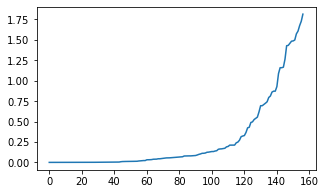

In [18]:
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [19]:
DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")
DBSCAN_clustering.fit(distance_matrix)

DBSCAN(eps=1, metric='precomputed', min_samples=1)

## DBSCAN Clustering Output

In [20]:
DBSCAN_clustering.labels_

array([ 0,  0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  5,  0,  6,  7,  8,  7,  8,  7,  7,  7,  7,  6,  6,
        0,  0,  0,  0,  9,  0, 10,  0,  0,  0,  0,  0,  0,  2, 11,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 12, 13, 14, 15, 16,  0,  0,  0,  0,  2,
        0,  0,  0, 17, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  5, 18, 19, 19, 19, 19, 20, 21, 22, 22,  0,  0, 23,  0,  7,  0,
        0,  0,  0,  0,  0,  0,  9, 10, 24,  0, 25, 10,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 26,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [21]:
print(len(DBSCAN_clustering.labels_), np.count_nonzero(DBSCAN_clustering.labels_ == -1))

157 0


In [22]:
DBSCAN_clustering.labels_.max()

26

## Stream a Single Attack

In [26]:
window = 10
offset = 1

DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")

print("Processing: ", attack_metadata_keys[0])
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[0], ground_truth_dbc_path)
# print(signal_multivar_ts.shape)

partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series
# print(len(partition_testing), partition_testing[0])

print("intervals: ", len(partition_testing))

# display(partition_testing[0])
# display(partition_testing[1])
# display(partition_testing[-1])

corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute correlation matrices
# display(corr_matrices_testing[0])

# total_length = int(np.ceil(timepts[-1]))
total_length = timepts[-1]
print("total length (s): ", total_length)  
intervals_testing = create_time_intervals(total_length, window/10, offset/10)
# print(len(intervals_testing), intervals_testing)
print("attack interval (s): ", attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

tp, fp, fn, tn = 0, 0, 0, 0

for index_interval in tqdm(range(len(intervals_testing))):

    # print("Interval: ", intervals_testing[index_interval])

    # print(np.isnan(corr_matrices_testing[index_interval]).any().any())
    # print((corr_matrices_testing[index_interval] < 0).any().any())

    # print(corr_matrices_testing[index_interval].shape)
    signal_names, distance_matrix = compute_distance_matrix(corr_matrices_testing[index_interval])
    # print(np.isnan(distance_matrix).any().any())
    # print((distance_matrix < 0))
    # display(distance_matrix[distance_matrix < 0])
    # print(type(signal_names), signal_names)
    
    DBSCAN_clustering.fit(distance_matrix)

    clustering_labels = DBSCAN_clustering.labels_
    
    unique_clustering_labels = np.unique(clustering_labels)

    # print(len(clustering_labels), len(unique_clustering_labels), clustering_labels)

    max_error_all_clusters = []

    for cluster_id in (unique_clustering_labels):
        
        index_of_interest = np.argwhere(clustering_labels == cluster_id).flatten()
        # print(cluster_id, len(index_of_interest), index_of_interest)
        # print(signal_names[index_of_interest])
        
        if len(index_of_interest) >= 2: # Check only clusters with at least two elements

            pd_corr_matrix = pd.DataFrame(corr_matrices_testing[index_interval], index=signal_names, columns=signal_names)
            # display(pd_distance_matrix)
            matrix_of_interest = pd_corr_matrix.loc[signal_names[index_of_interest], signal_names[index_of_interest]]
            # display(matrix_of_interest)

            upper_matrix_of_interest = upper(matrix_of_interest)
            # display(upper_matrix_of_interest)

            mean_cluster = np.mean(upper_matrix_of_interest)
            std_cluster = np.std(upper_matrix_of_interest)
            # print(std_cluster)

            if std_cluster != 0:

                error_cluster = np.absolute(upper_matrix_of_interest - mean_cluster)
                error_cluster = error_cluster/std_cluster
                max_error_cluster = np.max(error_cluster)
                
                max_error_all_clusters.append(max_error_cluster)

            # break

    mean_max_error_all_clusters = np.mean(max_error_all_clusters)
    std_max_error_all_clusters = np.std(max_error_all_clusters)
    
    # print("mean: ", mean_max_error_all_clusters, "std: ", std_max_error_all_clusters, "dist: ", max_error_all_clusters)
    
    # break

    if mean_max_error_all_clusters > 2.0: # positive detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
               or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                   or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            tp += 1
        else:
            fp += 1
    else: # negative detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
               or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                   or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            fn += 1
        else:
            tn += 1
            
# precision
if tp + fp != 0:            
    precision = tp/(tp + fp)
else:
    precision = np.nan

# recall
if tp + fn != 0:
    recall = tp/(tp + fn)
else:
    recall = np.nan

# f1
if precision + recall != 0:
    f1 = 2*((precision*recall)/(precision + recall))

else:
    f1 = np.nan

# fpr
if fp + tn != 0:
    fpr = fp/(fp + tn)
else:
    fpr = np.nan

# fnr
if fn + tp != 0:
    fnr = fn/(fn + tp)
else:
    fnr = np.nan

# mcc
if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
    mcc = (tp*tn) - (fp*fn)
else:
    mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
intervals:  331
total length (s):  33.9
attack interval (s):  9.191851 30.050109


100%|██████████| 330/330 [00:01<00:00, 320.87it/s]

tp: 143, tn: 49, fp: 62, fn: 76
precision: 0.698, recall: 0.653, f1: 0.675, fpr: 0.559, fnr: 0.347, mcc: 0.092
positive_intervals: 219.000, negative_intervals: 111.000



## Stream All Attacks

In [28]:
window = 10
offset = 1

DBSCAN_clustering = DBSCAN(eps=1, min_samples=1, metric="precomputed")

for index_attack in range(len(attack_metadata_keys)):

    print("Processing: ", attack_metadata_keys[index_attack])
    signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[index_attack], ground_truth_dbc_path)
    
    partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series

    print("intervals: ", len(partition_testing))

    # display(partition_testing[0])
    # display(partition_testing[1])
    # display(partition_testing[-1])

    corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute correlation matrices
    # display(corr_matrices_testing[0])

    # total_length = int(np.ceil(timepts[-1]))  
    total_length = timepts[-1]
    print("total length (s): ", total_length)
    intervals_testing = create_time_intervals(total_length, window/10, offset/10)
    # print(len(intervals_testing), intervals_testing)
    print("attack interval (s): ", attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0], attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])

    tp, fp, fn, tn = 0, 0, 0, 0

    for index_interval in range(len(intervals_testing)):

        # print("Interval: ", intervals_testing[index_interval])

        # print(np.isnan(corr_matrices_testing[index_interval]).any().any())
        # print((corr_matrices_testing[index_interval] < 0).any().any())

        # print(corr_matrices_testing[index_interval].shape)
        signal_names, distance_matrix = compute_distance_matrix(corr_matrices_testing[index_interval])
        # print(np.isnan(distance_matrix).any().any())
        # print((distance_matrix < 0))
        # display(distance_matrix[distance_matrix < 0])
        # print(type(signal_names), signal_names)
        
        DBSCAN_clustering.fit(distance_matrix)

        clustering_labels = DBSCAN_clustering.labels_
        
        unique_clustering_labels = np.unique(clustering_labels)

        # print(len(clustering_labels), len(unique_clustering_labels), clustering_labels)

        max_error_all_clusters = []

        for cluster_id in (unique_clustering_labels):
            
            index_of_interest = np.argwhere(clustering_labels == cluster_id).flatten()
            # print(cluster_id, len(index_of_interest), index_of_interest)
            # print(signal_names[index_of_interest])
            
            if len(index_of_interest) >= 2 and cluster_id != -1: # Check only clusters with at least two elements that are NOT outliers

                pd_corr_matrix = pd.DataFrame(corr_matrices_testing[index_interval], index=signal_names, columns=signal_names)
                # display(pd_distance_matrix)
                matrix_of_interest = pd_corr_matrix.loc[signal_names[index_of_interest], signal_names[index_of_interest]]
                # display(matrix_of_interest)

                upper_matrix_of_interest = upper(matrix_of_interest)
                # display(upper_matrix_of_interest)

                mean_cluster = np.mean(upper_matrix_of_interest)
                std_cluster = np.std(upper_matrix_of_interest)
                # print(std_cluster)

                if std_cluster != 0:

                    error_cluster = np.absolute(upper_matrix_of_interest - mean_cluster)
                    error_cluster = error_cluster/std_cluster
                    max_error_cluster = np.max(error_cluster)
                    
                    max_error_all_clusters.append(max_error_cluster)

                # break

        mean_max_error_all_clusters = np.mean(max_error_all_clusters)
        std_max_error_all_clusters = np.std(max_error_all_clusters)
        
        # print("mean: ", mean_max_error_all_clusters, "std: ", std_max_error_all_clusters, "dist: ", max_error_all_clusters)
        
        # break

        if mean_max_error_all_clusters > 2.0: # positive detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
                or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                    or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
                tp += 1
            else:
                fp += 1
        else: # negative detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
                or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                    or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
                fn += 1
            else:
                tn += 1
                
    # precision
    if tp + fp != 0:            
        precision = tp/(tp + fp)
    else:
        precision = np.nan

    # recall
    if tp + fn != 0:
        recall = tp/(tp + fn)
    else:
        recall = np.nan

    # f1
    if precision + recall != 0:
        f1 = 2*((precision*recall)/(precision + recall))

    else:
        f1 = np.nan

    # fpr
    if fp + tn != 0:
        fpr = fp/(fp + tn)
    else:
        fpr = np.nan

    # fnr
    if fn + tp != 0:
        fnr = fn/(fn + tp)
    else:
        fnr = np.nan

    # mcc
    if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
        mcc = (tp*tn) - (fp*fn)
    else:
        mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
    print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
    print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
intervals:  331
total length (s):  33.9
attack interval (s):  9.191851 30.050109
tp: 143, tn: 49, fp: 62, fn: 76
precision: 0.698, recall: 0.653, f1: 0.675, fpr: 0.559, fnr: 0.347, mcc: 0.092
positive_intervals: 219.000, negative_intervals: 111.000

Processing:  correlated_signal_attack_2_masquerade
intervals:  281
total length (s):  28.9
attack interval (s):  6.830477 28.225908
tp: 109, tn: 10, fp: 72, fn: 89
precision: 0.602, recall: 0.551, f1: 0.575, fpr: 0.878, fnr: 0.449, mcc: -0.312
positive_intervals: 198.000, negative_intervals: 82.000

Processing:  correlated_signal_attack_3_masquerade
intervals:  161
total length (s):  16.9
attack interval (s):  4.318482 16.95706
tp: 44, tn: 28, fp: 54, fn: 35
precision: 0.449, recall: 0.557, f1: 0.497, fpr: 0.659, fnr: 0.443, mcc: -0.104
positive_intervals: 79.000, negative_intervals: 82.000

Processing:  max_speedometer_attack_1_masquerade
intervals:  881
total length (s):  88.9
attack inte

## Clustering with HDBSCAN

In [57]:
HDBSCAN_clustering = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric="precomputed")
HDBSCAN_clustering.fit(distance_matrix)

HDBSCAN(metric='precomputed', min_samples=1)

## HDBSCAN Clustering Output

In [58]:
HDBSCAN_clustering.labels_

array([11,  5,  7, -1,  7,  1,  5, 11, -1,  6, -1, -1,  4,  7,  8,  2, 11,
       11, -1, 11, 11, -1, -1,  6,  1, 11,  2, -1, -1,  6, -1, -1, -1,  1,
       10,  4,  5,  4,  7, 11,  8,  8, -1, -1,  1, -1, 11, 11, -1,  0,  0,
       -1,  0, -1,  0,  0,  0,  0, -1, -1, -1, 11, -1,  3, -1, -1, 11,  6,
       11, 11, -1,  4, -1,  1,  5,  5, 11,  7,  7, -1, -1,  1,  1,  3, -1,
       -1,  7,  6, -1,  6, -1,  7,  7,  5,  6, -1,  5,  7, -1, 11,  0, -1,
       10, -1, 10, -1, -1,  6, 11, 12, 11, -1,  1,  5,  3, -1, -1, -1, 10,
       10,  9, -1, -1,  6,  8, -1,  5, -1, -1,  7, 11,  9, 10, -1, -1, 10,
       -1, -1, -1, -1, -1, -1, -1, -1,  4, -1,  2,  2, -1,  6,  1, -1,  0,
       11, -1, 12,  9, 11,  9,  9, 11,  4, -1,  1,  4, 11, -1,  1, 11,  2,
       -1, 11, -1,  8, -1, 10,  5, 12,  7, 10,  3, 11, -1, 12, 11, -1, 12,
       11, 11, 11,  6,  6,  6,  6,  9,  5,  6,  3, -1,  9])

In [59]:
print(len(HDBSCAN_clustering.labels_), np.count_nonzero(HDBSCAN_clustering.labels_ == -1))

200 69


In [60]:
HDBSCAN_clustering.labels_.max()

12